In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.reset_option('display.max_rows')
#from IPython.display import display
#with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#    display(df)
pd.set_option('display.max_colwidth',150)


**Creating a cutout**

In [3]:
#the cutout is delimited by a border drawn between Outer Hebrides, Kattegat, Strait of Dover as well as Shetland and Orkney Islands

cutout = atlite.Cutout(path="north-sea-region-jan21.nc",
                       module="era5",
                       x=slice(-4.2600, 10.0000),
                       y=slice(51.4000, 60.8479),
                       time=slice("2021-01-15","2021-02-15") # until 25th of Jan: time=slice("2019-03-01","2019-03-31")
                       )


In [4]:
cutout.prepare()

INFO:atlite.data:Cutout already prepared.


<Cutout "north-sea-region-jan21">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [5]:
cutout.data
cutout.wind
cutout.prepared_features


<xarray.Dataset>
Dimensions:           (x: 58, y: 38, time: 768)
Coordinates:
  * x                 (x) float64 -4.25 -4.0 -3.75 -3.5 ... 9.25 9.5 9.75 10.0
  * y                 (y) float64 51.5 51.75 52.0 52.25 ... 60.25 60.5 60.75
  * time              (time) datetime64[ns] 2021-01-15 ... 2021-02-15T23:00:00
    lon               (x) float64 dask.array<chunksize=(58,), meta=np.ndarray>
    lat               (y) float64 dask.array<chunksize=(38,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 dask.array<chunksize=(38, 58), meta=np.ndarray>
    wnd100m           (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    roughness         (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_toa        (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    influx_direct     (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    temperature       (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    soil temperature  (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
    runoff            (time, y, x) float32 dask.array<chunksize=(100, 38, 58), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'influx', 'wind', 'height', 'temperature']
    chunksize_time:     100
    Conventions:        CF-1.6
    history:            2023-01-25 22:37:52 GMT by grib_to_netcdf-2.25.1: /op...

<bound method wind of <Cutout "north-sea-region-jan21">
 x = -4.25 ⟷ 10.00, dx = 0.25
 y = 51.50 ⟷ 60.75, dy = 0.25
 time = 2021-01-15 ⟷ 2021-02-15, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

**Importing country shapefiiles**

In [6]:
from shapely.geometry import Polygon
import geopandas

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
#Select the north sea bordering states
BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

cells = cutout.grid
projection = ccrs.Orthographic( -5,30)
country_bound = gpd.GeoSeries(cells.unary_union)

**Plotting the cutout with abstract land borders**

(-4.375, 51.375, 10.125, 60.875)

<GeoAxesSubplot:>

<GeoAxesSubplot:>

<GeoAxesSubplot:>

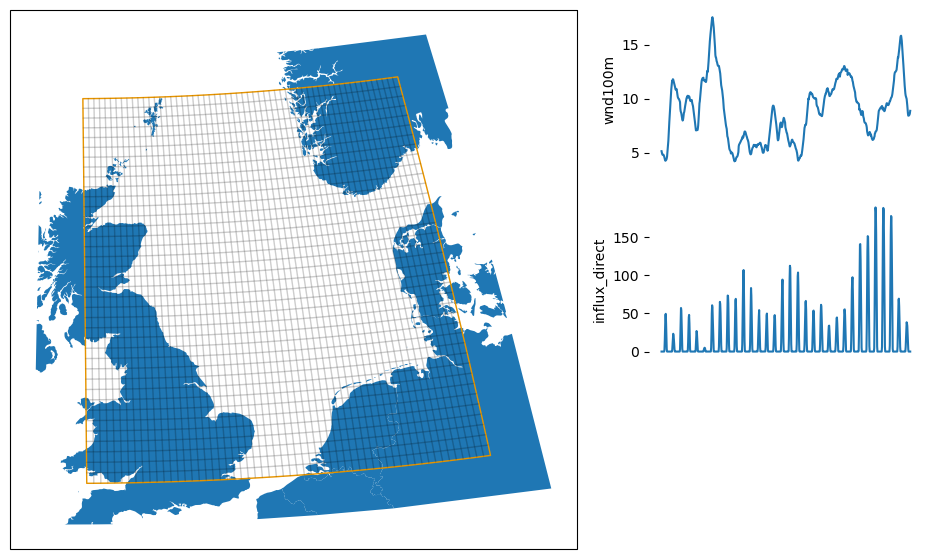

In [7]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig) 

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

# we need to clip the predefined country border because they extend to Southern France and Svalbard

# a visual cutout of the north sea region is slightly larger than the actual cutout
display(cells.unary_union.bounds)
lat_point_list = [50.4,61.8479, 61.8479, 50.4,50.4]
lon_point_list = [-6.26, -6.26 , 12 ,12, -6.26 ]
polygon2 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf2 = gpd.GeoDataFrame([1], geometry=[polygon2], crs=cutout.grid.crs)
BorderingStates_init= BorderingStates_init.clip(poly_gdf2)

BorderingStates_init.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())

#ax.outline_patch.set_edgecolor('black')
ax.set_frame_on(True)
#a remnant of the tutorial: some weather data are plotted alongside
#so far, I want to keep the gridspec-layout
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

#set_xlim und set_ylim funktionieren nicht 
#ax. set_extent([-4.375, 51.375, 10.125, 60.875],crs=geodetic()) auch nicht

**Plotting the windfarms from EMODNet with a map from OpenStreetMap**

Text(0.5, 1.0, 'First step: All wind farms of north sea bordering states')

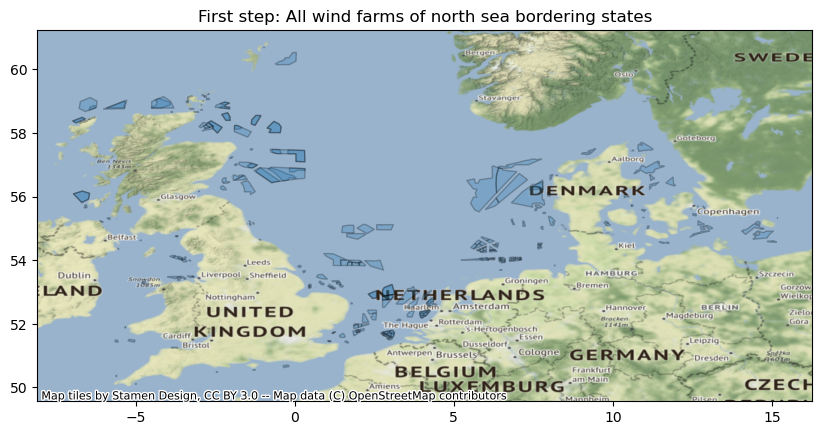

In [8]:
import contextily as cx

#data of European Offshore wind farms is imported
windfarm_map = gpd.read_file("../data/Windfarm-Shapefiles/EMODnet_HA_WindFarms_pg_20220324.shp")
# Firstly, we reduce the set to north sea bordering countries
windfarm_map=windfarm_map[windfarm_map["COUNTRY"].isin(['United Kingdom','Denmark','Belgium','Norway','Germany','Netherlands'])]

#France is also a potential bordering nation, but the potential site in the area (parc eolien dunkerque)
#is not comprised within the dataset
#it will not be built before 2024 anyway

#contextily chooses the right zoom factor automatically
ax = windfarm_map.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map.crs) # der passende Ausschnitt wird zugewiesen
ax.set_title("First step: All wind farms of north sea bordering states")

#this would work, but not cartopy set-lim(minx,maxx,minym,maxy)
#ax.set_xlim(-1.2600, 5.0000)
#ax.set_ylim(50.4, 53.8)

#strangely the suggested method in the documentation does not work
#windfarm_map.to_crs(epsg=3857)
#fig, ax = plt.subplots (figsize = (15,15))
#windfarm_map.plot(ax=ax)
#cx.add_basemap(ax=ax,crs= 3857)
#cx.add_basemap(ax)


The data contains necessarily wind farms beyond the North Sea due to country as a selection criterion.

**Plot only windfarms, that are located in the cutout**

Index(['OBJECTID', 'COUNTRY', 'NAME', 'N_TURBINES', 'POWER_MW', 'STATUS',
       'YEAR', 'COAST_DIST', 'AREA_SQKM', 'NOTES', 'Shape_Leng', 'Shape_Area',
       'geometry'],
      dtype='object')

,OBJECTID,COUNTRY,NAME,N_TURBINES,POWER_MW,STATUS,YEAR,COAST_DIST,AREA_SQKM,NOTES,Shape_Leng,Shape_Area,geometry
7,8,Belgium,Rentel,42,309.00,Production,2018,28354.728982,23.264154,None,0.260649,0.003017,"POLYGON ((2.88724 51.59085, 2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51..."
8,9,Belgium,Norther,44,370.00,Production,2018,19797.758680,38.445331,None,0.352805,0.004979,"POLYGON ((3.04002 51.51200, 2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51..."
9,10,Belgium,Seastar,30,252.00,Production,2020,36085.954019,18.426179,None,0.222749,0.002392,"POLYGON ((2.86386 51.61521, 2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51..."
10,11,Belgium,Mermaid,28,235.20,Production,2020,48314.549431,16.676150,None,0.208196,0.002169,"POLYGON ((2.79057 51.71872, 2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51..."
11,12,Belgium,C-Power (Zone A),24,141.15,Production,2013,24793.536916,10.682070,None,0.174694,0.001384,"POLYGON ((2.88360 51.54680, 2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680))"


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Second_step, All wind farms within the cutout')

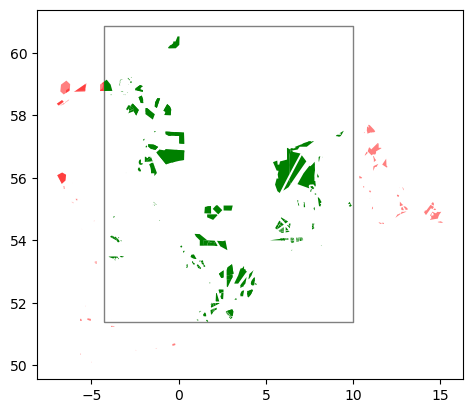

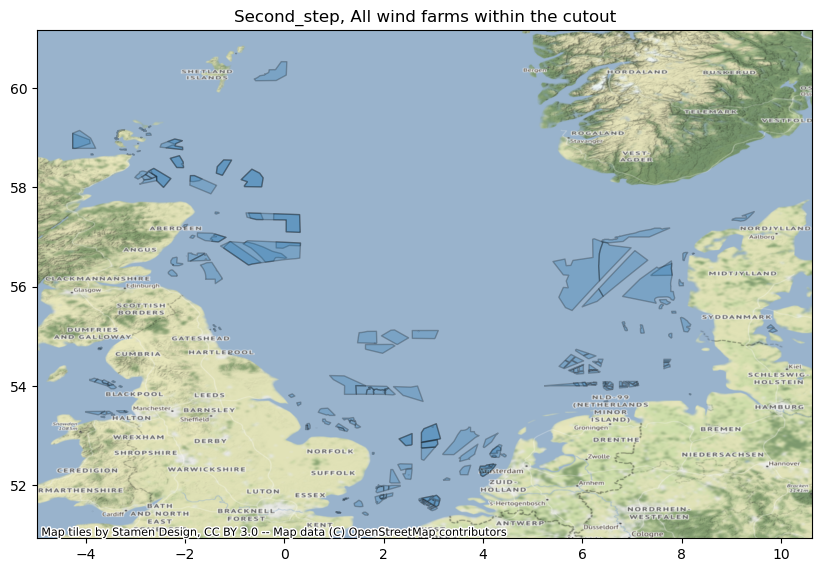

In [9]:
windfarm_map.columns
windfarm_map.head()

#take the polygon from the initial cutout and use it to reduce the initial country-based dataset
# a selection based on visual adherence to the region is not viable since the objectids have no geograpic correlation
#and the dataset containts more than 200 windfarms
lat_point_list = [51.4,60.8479, 60.8479,51.4,51.4]
lon_point_list = [-4.26, -4.26 , 10 ,10, -4.26 ]
polygon3 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf3 = gpd.GeoDataFrame([1], geometry=[polygon3], crs=windfarm_map.crs)

fig, (ax) = plt.subplots()
poly_gdf3.plot(ax=ax,color='white', edgecolor='grey')
windfarm_map.plot(ax=ax,zorder=0,color= 'red',alpha= 0.5)

windfarm_map_reduced = gpd.overlay(windfarm_map,poly_gdf3, how='intersection')
#that function also eliminates polygons outside of the scope of polygon 3 from our GeoPandas Dataframe
# but will also cut off border polygons 

#reindex took place automatically during overlay-method, else: df.reset_index()
#objectid serves as  unique identifiert
windfarm_map_reduced.plot(ax=ax,color='green')

#contextily plotting of windfarms on topographic map
ax = windfarm_map_reduced.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_map_reduced.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Second_step, All wind farms within the cutout")

#display(windfarm_map_reduced)

**Discard windfarms, that are not located in the North Sea**

**i.e. off the coast of Cardif** : Bristol Channel <br> **in the Irish Sea** Liverpool Bay and Morecambe Bay

(224, 14)

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 1.0, 'Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea')

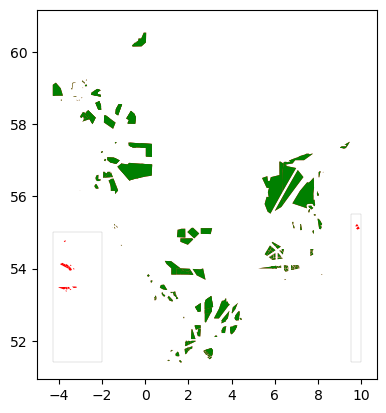

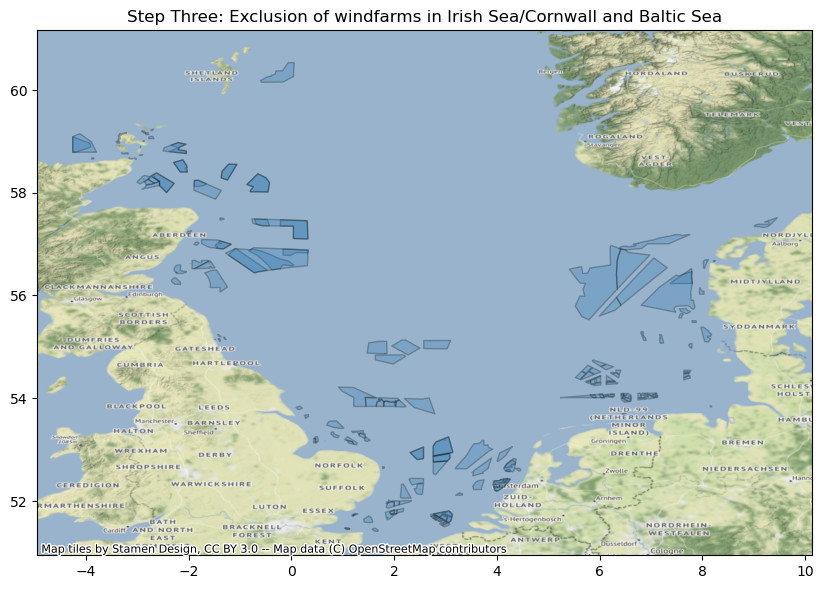

In [10]:

windfarm_map_reduced.shape

#define areas that are to be discarded
#again: selection is done by polygons instead of hand-selecting

#Irish Sea
lat_point_list = [51.4,55.0, 55.0,51.4,51.4]
lon_point_list = [-4.26, -4.26 , -2 ,-2, -4.26 ]
polygon4 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_west = gpd.GeoDataFrame([1], geometry=[polygon4], crs=windfarm_map_reduced.crs)

#Baltic Sea
lat_point_list = [51.4,55.5, 55.5,51.4,51.4]
lon_point_list = [9.5, 9.5 , 10 ,10, 9.5 ]
polygon5 = Polygon(zip(lon_point_list, lat_point_list))
poly_gdf_excl_east = gpd.GeoDataFrame([1], geometry=[polygon5], crs=windfarm_map_reduced.crs)

#within-function demands a gp-series, the argument needs to be a shapely-object
bool1= windfarm_map_reduced.within(polygon4) #ergibt eine Boolean-Tabelle
bool2= windfarm_map_reduced.within(polygon5)
#use boolean logic to create a mask that excludes both areas
bool3= bool1 + bool2

#windfarm_map_reduced
#use boolean filtering
windfarm_new= windfarm_map_reduced[~bool3.values]

#windfarm_map_reduced = windfarm_map_reduced[windfarm_map_reduced.within(polygon3) ==False]

fig,ax1 =plt.subplots()

windfarm_map_reduced.plot(ax=ax1,color='red',zorder=0)
windfarm_new.plot(ax=ax1,color='green')
poly_gdf_excl_east.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)
poly_gdf_excl_west.plot(ax=ax1,color='none',edgecolor='grey',linewidth=0.15)

#contextily plotting of windfarms on topographic map
ax = windfarm_new.plot(figsize=(10, 10), alpha=0.25, edgecolor='k')
cx.add_basemap(ax, crs=windfarm_new.crs) # der passende Ausschnitt wird zugewiesen
##ax.axis("off")
ax.set_title("Step Three: Exclusion of windfarms in Irish Sea/Cornwall and Baltic Sea")
#




In [268]:

windfarm_new.reset_index(drop=True, inplace=True)
windfarm_new.shape
pd.set_option('display.max_rows', 1000)

windfarm_new


(204, 14)

,OBJECTID,COUNTRY,NAME,N_TURBINES,POWER_MW,STATUS,YEAR,COAST_DIST,AREA_SQKM,NOTES,Shape_Leng,Shape_Area,0,geometry
0,8,Belgium,Rentel,42,309.00,Production,2018,28354.728982,23.264154,None,0.260649,0.003017,1,"POLYGON ((2.90552 51.59822, 2.91429 51.59965, 2.93139 51.60670, 2.93972 51.61086, 2.95537 51.61985, 3.00353 51.59084, 2.99282 51.58800, 2.98329 51..."
1,9,Belgium,Norther,44,370.00,Production,2018,19797.758680,38.445331,None,0.352805,0.004979,1,"POLYGON ((2.97331 51.48950, 2.93681 51.51286, 2.94508 51.51529, 2.97299 51.52806, 2.97883 51.53398, 2.98698 51.53413, 2.99118 51.53645, 2.99906 51..."
2,10,Belgium,Seastar,30,252.00,Production,2020,36085.954019,18.426179,None,0.222749,0.002392,1,"POLYGON ((2.84370 51.60708, 2.83087 51.60788, 2.81428 51.61465, 2.81934 51.61971, 2.83984 51.63631, 2.85773 51.65052, 2.86800 51.65772, 2.87846 51..."
3,11,Belgium,Mermaid,28,235.20,Production,2020,48314.549431,16.676150,None,0.208196,0.002169,1,"POLYGON ((2.78949 51.71814, 2.78900 51.71771, 2.78857 51.71722, 2.78790 51.71661, 2.78748 51.71613, 2.75580 51.71063, 2.75513 51.71045, 2.71777 51..."
4,12,Belgium,C-Power (Zone A),24,141.15,Production,2013,24793.536916,10.682070,None,0.174694,0.001384,1,"POLYGON ((2.90836 51.55810, 2.96208 51.53428, 2.93766 51.52309, 2.92797 51.52018, 2.88360 51.54680, 2.90836 51.55810))"
5,13,Belgium,C-Power (Zone B),30,184.50,Production,2013,25036.117115,9.169407,None,0.167815,0.001188,1,"POLYGON ((3.01127 51.57743, 3.00446 51.57128, 3.01785 51.56379, 3.00503 51.55993, 2.99597 51.55509, 2.98756 51.54976, 2.97854 51.54401, 2.95222 51..."
6,14,Belgium,Northwind,72,216.00,Production,2014,33657.535000,8.741283,None,0.195543,0.001134,1,"POLYGON ((2.86010 51.60298, 2.89200 51.61585, 2.88862 51.61788, 2.90553 51.62469, 2.91273 51.62830, 2.92687 51.63656, 2.94461 51.62589, 2.93036 51..."
7,15,Belgium,Belwind phase 1,55,165.00,Production,2010,40610.684576,14.740648,None,0.208410,0.001915,1,"POLYGON ((2.82470 51.69078, 2.82334 51.68850, 2.82699 51.68750, 2.83919 51.68922, 2.83920 51.68921, 2.83795 51.68712, 2.79420 51.63259, 2.79198 51..."
8,16,Belgium,Northwester 2,23,219.00,Production,2020,44480.727405,11.732646,None,0.176358,0.001525,1,"POLYGON ((2.75160 51.65564, 2.75126 51.65579, 2.72129 51.68823, 2.75869 51.70642, 2.78437 51.71082, 2.75160 51.65564))"
9,17,Belgium,Belwind phase 2 (Nobelwind) (Zone 2),50,165.00,Production,2017,39176.949578,13.825658,None,0.204922,0.001796,1,"POLYGON ((2.83795 51.68712, 2.83920 51.68921, 2.86756 51.67240, 2.80154 51.61950, 2.79420 51.63259, 2.83795 51.68712))"


**Reading in  **

In [281]:
turbines_atlite= [t for t in atlite.windturbines] #list comprehension                    
turbines_atlite =pd.Series(turbines_atlite)
turbines_atlite
#for t in atlite.windturbines: print(f'* {t}') #displaying all built-in turbines

#if turbines have been imported, their name will show up here

0                                 Bonus_B1000_1000kW
1                                Enercon_E101_3000kW
2                                Enercon_E126_7500kW
3                                 Enercon_E82_3000kW
4     NREL_ReferenceTurbine_2016CACost_10MW_offshore
5      NREL_ReferenceTurbine_2016CACost_6MW_offshore
6      NREL_ReferenceTurbine_2016CACost_8MW_offshore
7     NREL_ReferenceTurbine_2019ORCost_12MW_offshore
8     NREL_ReferenceTurbine_2019ORCost_15MW_offshore
9        NREL_ReferenceTurbine_2020ATB_12MW_offshore
10       NREL_ReferenceTurbine_2020ATB_15MW_offshore
11       NREL_ReferenceTurbine_2020ATB_18MW_offshore
12                 NREL_ReferenceTurbine_2020ATB_4MW
13               NREL_ReferenceTurbine_2020ATB_5.5MW
14                 NREL_ReferenceTurbine_2020ATB_7MW
15                NREL_ReferenceTurbine_5MW_offshore
16                            Siemens_SWT_107_3600kW
17                                Siemens_SWT_2300kW
18                                 Suzlon_S82_

Horns Rev 2 turbine type:Siemens SWT-2.3-93 source: https://www.thewindpower.net/windfarm_de_7064_horns-rev-2.php

New Turbine Power curves can be found under: https://openenergy-platform.org/dataedit/view/supply/wind_turbine_library
An ATLITE command imports these for further processing

In [13]:
used_turbines= pd.DataFrame(data=windfarm_new[['OBJECTID','COUNTRY','NAME','STATUS']])
len(used_turbines)
windfarm_new.iloc[15,1]


204

'Germany'

In [14]:
import requests
import numpy as np
OEDB_URL = "https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows"

# Cache turbine request locally

# Get the turbine list
result = requests.get(OEDB_URL)
# Convert JSON to dataframe for easier filtering
# Only consider turbines with power curves available
df = pd.DataFrame.from_dict(result.json())
oedb_turbines = df[df.has_power_curve]

In [15]:
#df
oedb_turbines.shape
oedb_turbines_mask = df[['id']].isin(oedb_turbines)
oedb_turbines_mask.rename({'id':'has_power_curve'},axis=1,inplace=True)
oedb_turbines_mask
oedb_turbines_mask.value_counts()
oedb_turbines_mask.sum()



(68, 25)

,has_power_curve
0,True
1,True
2,True
3,True
4,True
...,...
136,True
137,True
138,True
139,True


has_power_curve
False              73
True               68
dtype: int64

has_power_curve    68
dtype: int64

In [16]:
#goal: have a list of all turbines in the external source, so that I can add these manually in a .xlsx to each North Sea windpark

pd.set_option('display.max_rows',1000)

new_turbines= pd.read_csv("..\data\supply__wind_turbine_library.csv")
#name, turbine_name , turbiney_type vary greatly; often name components are missing, so addition of all strings
#turbine_ids are not sorted in the original file
#ids are retained, in case I want to use the specific turbine type
new_turbines['agg_name'] = new_turbines['manufacturer'].fillna('') + ' ' +new_turbines['name'].fillna('') +' ' + new_turbines['turbine_type'].fillna('')
#adding both lists
new_turbines1= pd.concat([new_turbines['agg_name'], turbines_atlite],axis=0,ignore_index=True)

new_turbines2= pd.concat([new_turbines['id'].astype(str),new_turbines1],axis=1,ignore_index=True)
new_turbines2.rename(columns={0: "id", 1: "new_name"},inplace=True)

#there are duplicates in this list, due to incoherent naming
#if ATLITE uses the suppl__Wind_turbine__library.csv , it might have a way to deal with that?

In [17]:


#adding an empty column for manual entries
#adding the list of possible turbines for excel-function data validation/drop-down menü
#adding a mask, whether the OEDB-entry has a power curve, which is filtered by the subsequent get_oedb_windturbineconfig anyway
used_turbines= pd.concat([used_turbines,pd.DataFrame({'TURBINE_TYPE' : []}),new_turbines2,oedb_turbines_mask],axis=1)
used_turbines

,OBJECTID,COUNTRY,NAME,STATUS,TURBINE_TYPE,id,new_name,has_power_curve
0,8,Belgium,Rentel,Production,NaN,0,Enercon E-141/4200 EP 4 E-141/4200,True
1,9,Belgium,Norther,Production,NaN,1,Enercon E-126/4200 EP4 E-126/4200,True
2,10,Belgium,Seastar,Production,NaN,2,Enercon E-101/3500 E2 E-101/3500,True
3,11,Belgium,Mermaid,Production,NaN,3,Enercon E-115/3200 E-115/3200,True
4,12,Belgium,C-Power (Zone A),Production,NaN,4,Enercon E-101/3050 E2 E-101/3050,True
5,13,Belgium,C-Power (Zone B),Production,NaN,5,Enercon E-115/3000 E-115/3000,True
6,14,Belgium,Northwind,Production,NaN,6,Enercon E-82/3000 E-82/3000,True
7,15,Belgium,Belwind phase 1,Production,NaN,108,Vensys VENSYS77 1.5MW VS77/1500,False
8,16,Belgium,Northwester 2,Production,NaN,109,Vensys VENSYS70 1.5MW VS70/1500,False
9,17,Belgium,Belwind phase 2 (Nobelwind) (Zone 2),Production,NaN,110,GE Wind Haliade 150-6MW GE150/6000,False


**Writing a preliminary Mini-Database to Excel-File**

In [18]:
#this file already exists, new entries are entered into the copy \WiP_Eingabe_Turbinen.xlsx
#used_turbines.to_excel(r"C:\Users\march\Desktop\oweg-int-NSR\data\Turbine_types.xlsx" ,sheet_name="Sheet1")

In [19]:
#an example how the ATLITE method collects new windturbines from open energy platform
#but will only request turbines that have a power curve
from atlite.resource import get_oedb_windturbineconfig
get_oedb_windturbineconfig(id=52)

#from the API
#atlite.resource.get_windturbineconfig("Siemens_SWT_2300kW") #preinstalled 
#this method can be combined with oedb /  
#atlite.resource.get_windturbineconfig("oedb:V112-3.0 MW") #requested from oedb: one needs the "name" attribute from the table

#get_oedb_windturbineconfig(manufacturer="Nordex")

#an error message for "Nordex" is to be expected since there are multiple entries with

INFO:atlite.resource:Searching turbine power curve in OEDB database using id='52'.


{'name': 'V112/3000',
 'manufacturer': 'Vestas',
 'source': 'Original: http://www.windenergie-im-binnenland.de/powercurve.php. Via OEDB https://openenergy-platform.org/api/v0/schema/supply/tables/wind_turbine_library/rows',
 'hub_height': 100,
 'V': array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,
         8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5,
        14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. ,
        19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5,
        25. ]),
 'POW': array([0.023, 0.068, 0.13 , 0.206, 0.301, 0.418, 0.557, 0.72 , 0.912,
        1.13 , 1.377, 1.654, 1.954, 2.272, 2.572, 2.808, 2.988, 3.046,
        3.065, 3.073, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075,
        3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075, 3.075]),
 'P': 3.075}

In [20]:
#from atlite.resource import get_oedb_windturbineconfig
#works_list= []
#new_list=[]
#for i in list(range(141)):
#    
#    try: get_oedb_windturbineconfig(i)
#    except:new_list.append(i) 
#    print(i)    
#print(new_list)

**Reference data from the ENTSOE-API**

In [240]:
import pandas as pd
#farms_be= pd.read_csv("..\data\BEoutfile.csv")
#farms_dk = pd.read_csv("..\data\DK_CAoutfile.csv")
#farms_gb= pd.read_csv("..\data\GBoutfile.csv")
##EIC_list = pd.read_excel(r"..\data\GB Electric EIC Library (External) upda.xlsx", sheet_name='ESO W Type Codes - BMUs')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#these data wre obtained via the ENTSOE-API
#farms_be= pd.read_csv("..\data\BE_1_outfile.csv")
#farms_dk = pd.read_csv("..\data\DK_CA_1_outfile.csv")
#farms_gb= pd.read_csv("..\data\GB_1_outfile.csv")
farms_be= pd.read_csv("..\data\BE_4_outfile.csv")
farms_dk = pd.read_csv("..\data\DK_CA_4_outfile.csv")
farms_gb= pd.read_csv("..\data\GB_4_outfile.csv")
EIC_list = pd.read_excel(r"..\data\GB Electric EIC Library (External) upda.xlsx", sheet_name='ESO W Type Codes - BMUs')

farms_be = farms_be.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_gb = farms_gb.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 
farms_dk = farms_dk.rename({'Unnamed: 0': 'TimeIndex'}, axis=1) 

#remove the first two columns, because they contain descriptors
###use timestamps as Index

 #Horns Rev 3 did not exist before August 2019
farms_dk.drop(labels=[0,1], axis=0,inplace=True)
farms_dk['TimeIndex'] = pd.to_datetime(farms_dk['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_dk = farms_dk.set_index('TimeIndex')
farms_dk = farms_dk.astype(float) #does not change the dtype of the index '#this assignment is necessary, since all values were read in as Strings

farms_be.drop(labels=[0,1], axis=0,inplace=True)
farms_be.set_index('TimeIndex',inplace=True) #other way around works too
farms_be.index = pd.to_datetime(farms_be.index,utc=True)
#type(farms_be.index)
farms_be = farms_be.astype(float) 


#British wind farms need to be translated via the EIC
#list  available at: https://www.nationalgrideso.com/document/167131/download
#EIC_list.head()
abbrev_list= farms_gb.columns.tolist()
translation_list = []
#for abbrev in abbrev_list:
    #translation_list.append((abbrev,EIC_list[EIC_list['Display Name']==abbrev]['EIC Name - Asset Name'].to_string(index=False)))
    
translation_dict = {abbrev : EIC_list[EIC_list['Display Name']==abbrev]['EIC Name - Asset Name'].to_string(index=False) for abbrev in abbrev_list}
#translation_list is a dictionary of abbreviation an actual name
translation_dict

pd.reset_option('display.max_rows')

farms_gb.drop(labels=[0,1], axis=0,inplace=True)
farms_gb['TimeIndex'] = pd.to_datetime(farms_gb['TimeIndex'],utc=True) #resample only works on a DateTimeIndex
farms_gb = farms_gb.set_index('TimeIndex')
farms_gb.index

#only british data are half-hourly
farms_gb = farms_gb.astype(float) 
farms_gb=farms_gb.resample('1H').mean()

#the translation list includes offshore windfarms in the Irish sea

{'TimeIndex': 'Series([], )',
 'ABRBO-1': 'Aberdeen Offshore Wind Farm',
 'BEATO-1': 'Beatrice Offshore Wind Farm ',
 'BEATO-2': 'Beatrice Offshore Wind Farm ',
 'BEATO-3': 'Beatrice Offshore Wind Farm ',
 'BEATO-4': 'Beatrice Offshore Wind Farm ',
 'BOWLW-1': 'Barrow Offshore Wind Farm BOWLW-1',
 'BRBEO-1': 'Burbo Extension BRBEO-1',
 'BURBW-1': 'Burbo Wind Farm BURBW-1',
 'DDGNO-1': 'Dudgeon Offshore Wind Farm DDGNO-1',
 'DDGNO-2': 'Dudgeon Offshore Wind Farm DDGNO-2',
 'DDGNO-3': 'Dudgeon Offshore Wind Farm DDGNO-3',
 'DDGNO-4': 'Dudgeon Offshore Wind Farm DDGNO-4',
 'EAAO-1': 'Series([], )',
 'EAAO-2': 'East Anglia One',
 'GAOFO-1': 'Galloper Offshore Wind Farm GAOFO-1',
 'GAOFO-2': 'Galloper Offshore Wind Farm GAOFO-2',
 'GAOFO-3': 'Galloper Offshore Wind Farm GAOFO-3',
 'GAOFO-4': 'Galloper Offshore Wind Farm GAOFO-4',
 'GNFSW-1': 'Gunfleet Sands GNFSW-1',
 'GNFSW-2': 'Gunfleet Sands GNFSW-2',
 'GRGBW-1': 'Greater Gabbard GRGBW-1',
 'GRGBW-2': 'Greater Gabbard GRGBW-2',
 'GRGBW-3

DatetimeIndex(['2021-01-15 00:00:00+00:00', '2021-01-15 00:30:00+00:00',
               '2021-01-15 01:00:00+00:00', '2021-01-15 01:30:00+00:00',
               '2021-01-15 02:00:00+00:00', '2021-01-15 02:30:00+00:00',
               '2021-01-15 03:00:00+00:00', '2021-01-15 03:30:00+00:00',
               '2021-01-15 04:00:00+00:00', '2021-01-15 04:30:00+00:00',
               ...
               '2021-02-15 19:00:00+00:00', '2021-02-15 19:30:00+00:00',
               '2021-02-15 20:00:00+00:00', '2021-02-15 20:30:00+00:00',
               '2021-02-15 21:00:00+00:00', '2021-02-15 21:30:00+00:00',
               '2021-02-15 22:00:00+00:00', '2021-02-15 22:30:00+00:00',
               '2021-02-15 23:00:00+00:00', '2021-02-15 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='TimeIndex', length=1536, freq=None)

In [22]:
farms_dk
#o = farms_dk['Horns Rev B']
#p = farms_gb['HOWAO-2']
#q = farms_be['Rentel Offshore WP']



,Anholt,Horns Rev A,Horns Rev B,Horns Rev C,Roedsand 1,Roedsand 2
TimeIndex,,,,,,
2021-01-15 00:00:00+00:00,151.0,27.0,50.0,104.0,25.0,41.0
2021-01-15 01:00:00+00:00,210.0,11.0,55.0,79.0,21.0,28.0
2021-01-15 02:00:00+00:00,337.0,2.0,26.0,45.0,24.0,50.0
2021-01-15 03:00:00+00:00,350.0,6.0,20.0,31.0,13.0,64.0
2021-01-15 04:00:00+00:00,267.0,6.0,8.0,16.0,20.0,62.0
...,...,...,...,...,...,...
2021-02-14 19:00:00+00:00,124.0,141.0,199.0,394.0,20.0,40.0
2021-02-14 20:00:00+00:00,134.0,141.0,199.0,395.0,19.0,43.0
2021-02-14 21:00:00+00:00,136.0,141.0,199.0,391.0,20.0,46.0


**Getting data from ATLITE**

In [269]:
#centroids
#rentel = windfarm_map[windfarm_map['NAME'] == 'Rentel']
#hornsea1 = windfarm_map[windfarm_map['NAME'] == 'Hornsea Project 1 (Heron East) Wind Farm'] # hat drei verschiende shapefiles, warum?
#hornsrev2 =windfarm_map[windfarm_map['NAME'] == 'Horns Rev II']
#
#rentel.centroid
#hornsea1.centroid
#hornsrev2.centroid
#

#centroids second try

northwind = windfarm_map[windfarm_map['NAME'] == 'Northwind']
humber = windfarm_map[windfarm_map['NAME'] == 'Humber Gateway Wind Farm']
hornsrev1 =windfarm_map[windfarm_map['NAME'] == 'Horns Rev I']
aberdeen = windfarm_map[windfarm_map['NAME'] == 'Aberdeen Bay Demo']

humber.centroid
northwind.centroid
hornsrev1.centroid
aberdeen.centroid






155    POINT (0.29312 53.64429)
dtype: geometry

13    POINT (2.90515 51.61596)
dtype: geometry

196    POINT (7.84055 55.48614)
dtype: geometry

62    POINT (-1.99493 57.22589)
dtype: geometry

In [276]:
#points are taken from the centroid data further down below

#sites = gpd.GeoDataFrame([['Rentel', 2.94454, 51.59140, 309],
#                          ['Horns Rev 2', 7.58275, 53.87785, 209.3],
#                          ['Hornsea 1',2.10926, 53.87785, 1300]],
#                         columns=['name', 'x', 'y', 'capacity']
#                         ).set_index('name')
#
#turbine types
#Horn Sea: Siemens SWT-7.0-154 SWT154/7000 #nicht in ooedb--> NREL_ReferenceTurbine_2016CACost_8MW_offshore
#Horns Rev Vestas V80-2.0 MW V80/2000  in oedb
#Rentel Siemesn SWT 7.0-154 nicht in oedb 

#hornsea ENTSO-E data are flawed, include only a fraction, admittedly: Honrsea 2 was only finished in August 2019
# the cutout is from march 2019 and so is the ENTSOE-Data

# as a consequence: select other wind farms, that were operational at the time and whose turbines are in the Database



#names are chosen to be the same as in the shapefile, but not mandatory
#capacities from wikipedia
sites = gpd.GeoDataFrame([['Humber Gateway Wind Farm',0.29312 ,53.64429, 219],
                        ['Northwind',2.90515, 51.61596, 216],
                        ['Horns Rev I', 7.84055 , 55.48614, 160],
                         ['Aberdeen Bay Demo',-1.99493 ,57.22589,93.2]],
                       columns=['name', 'x', 'y', 'capacity']
                       ).set_index('name')


#this is code remnant, but we use the axis of cap_factors for other operations
# the turbine has no effect on our results
cap_factors = cutout.wind(turbine='NREL_ReferenceTurbine_2016CACost_8MW_offshore', capacity_factor=True)


nearest = cutout.data.sel(
    {'x': sites.x.values, 'y': sites.y.values}, 'nearest').coords

sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

layout.count() #--> this mask containts three true values attached to the coordinates and nothing more
cells_generation #--> this enlarges the shapefile to fit the closest grid cell: a matrix with shapes that are identical
#to the cutout grid


#used turbines
#Northwind Vestas V112-3.0 MW ID52
#humber; Vestas V112-3.0 /Vestas V112-3.0 MW V112/3000 ID52
#horns rev i Vestas V80-2.0 MW V80/2000 ID 55
from atlite.resource import get_oedb_windturbineconfig
#get_oedb_windturbineconfig(id=52)
#get_oedb_windturbineconfig(id=55)


#laut Fehlemerldung gibt es mehrer Hub height,s in der Anfrage spezifizieren??

#for humber and northwind
#cutout.wind nutzt die methode windturbineconfig, laut API einfach oedb: vor den Namen setzen, Name = aus der Tabelle
#dann wird es automatisch ohne import Befehl geholt


power_generation1 = cutout.wind(atlite.windturbines['Vestas_V112_3000'], layout=layout, 
                              shapes=cells_generation.geometry) 

#Vestas V80 aus der oedb
power_generation2 = cutout.wind(get_oedb_windturbineconfig(id=55), layout=layout,
                              shapes=cells_generation.geometry)

#Aberdeen
power_generation3 = cutout.wind(get_oedb_windturbineconfig(id=33), layout=layout,
                              shapes=cells_generation.geometry)



h1 = power_generation1.to_pandas()
h2 = power_generation2.to_pandas()
h3= power_generation3.to_pandas()



INFO:atlite.convert:Convert and aggregate 'wind'.


<xarray.DataArray 'Installed Capacity [MW]' ()>
array(4)

,x,y,capacity,geometry
Humber Gateway Wind Farm,0.25,53.75,219.0,"POLYGON ((0.37500 53.62500, 0.37500 53.87500, 0.12500 53.87500, 0.12500 53.62500, 0.37500 53.62500))"
Northwind,3.00,51.50,216.0,"POLYGON ((3.12500 51.37500, 3.12500 51.62500, 2.87500 51.62500, 2.87500 51.37500, 3.12500 51.37500))"
Horns Rev I,7.75,55.50,160.0,"POLYGON ((7.87500 55.37500, 7.87500 55.62500, 7.62500 55.62500, 7.62500 55.37500, 7.87500 55.37500))"
Aberdeen Bay Demo,-2.00,57.25,93.2,"POLYGON ((-1.87500 57.12500, -1.87500 57.37500, -2.12500 57.37500, -2.12500 57.12500, -1.87500 57.12500))"


INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='55'.
INFO:atlite.convert:Convert and aggregate 'wind'.
INFO:atlite.resource:Searching turbine power curve in OEDB database using id='33'.
INFO:atlite.convert:Convert and aggregate 'wind'.


**ATLITE Kurven**

Text(0.5, 0.98, 'Synthetic ATLITE profiles')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

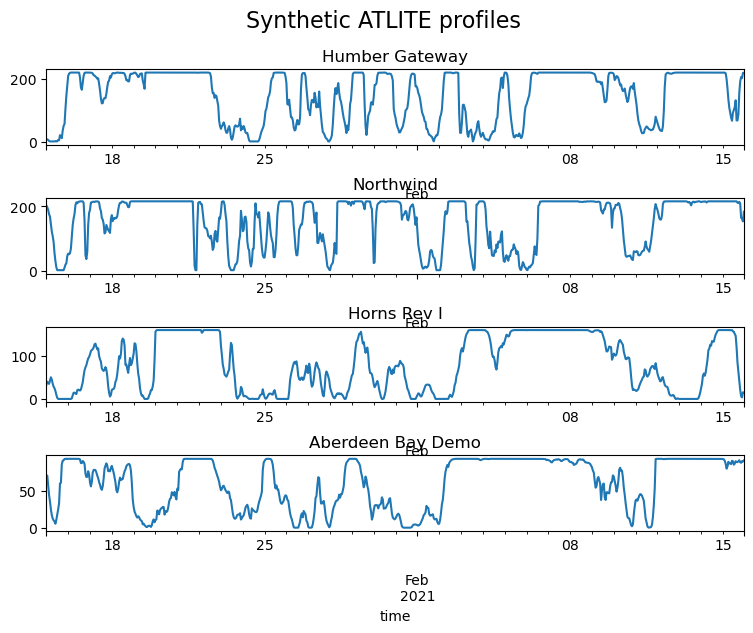

In [291]:
#fig, (ax1,ax2,ax3) =plt.subplots(3,1) #warum fehlen die Timestamps als Label?
#       #fig.set_title("ATLITE Generation profiles")
#    h['Hornsea 1'].plot(ax=ax1)
#    h['Horns Rev 2'].plot(ax=ax2)
#    h['Rentel'].plot(ax=ax3)



#names must macht the ones form the sites-dataframe

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1,figsize=(9,6)) #warum fehlen die Timestamps als Label?
fig.suptitle('Synthetic ATLITE profiles', fontsize=16)
h1['Humber Gateway Wind Farm'].plot(ax=ax1, title= 'Humber Gateway')
h1['Northwind'].plot(ax=ax2, title= 'Northwind')
# Horns rev 1 has a different set of turbines
h2['Horns Rev I'].plot(ax=ax3,title='Horns Rev I')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)


h3['Aberdeen Bay Demo'].plot(ax=ax4,title='Aberdeen Bay Demo')




**Plotting Horns Rev A. Northwind and Humber Gateway**

Strange: i only plotted HOWOA-2, because data is only available for that part
there are Hornsea1,2,3
Hornsea:
One: 1.218 MW
Two: 1.386 MW
Three: 2.852 MW
bis zu 6.000 MW (ganzes Potentialgebiet)
Eigentümer 	Ørsted
Gründung 	Monopiles[1][2]
Turbine 	One: 174 × Siemens Gamesa SWT-7.0-154
Two: 165 × SG 8.0-167 DD 

Lösung: Became fully operational on 31 August 2022
also wird es vorher geringere kapzität gehabt haben

war die faktische Einspeisung gering, weil der Park noch klein war? 

Text(0.5, 0.98, 'ATLITE blue vs ENTSOE red, mid of Jan 21')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='TimeIndex'>

(0.0, 262.8)

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='TimeIndex'>

(0.0, 259.2)

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='TimeIndex'>

(0.0, 192.0)

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='TimeIndex'>

(0.0, 111.84)

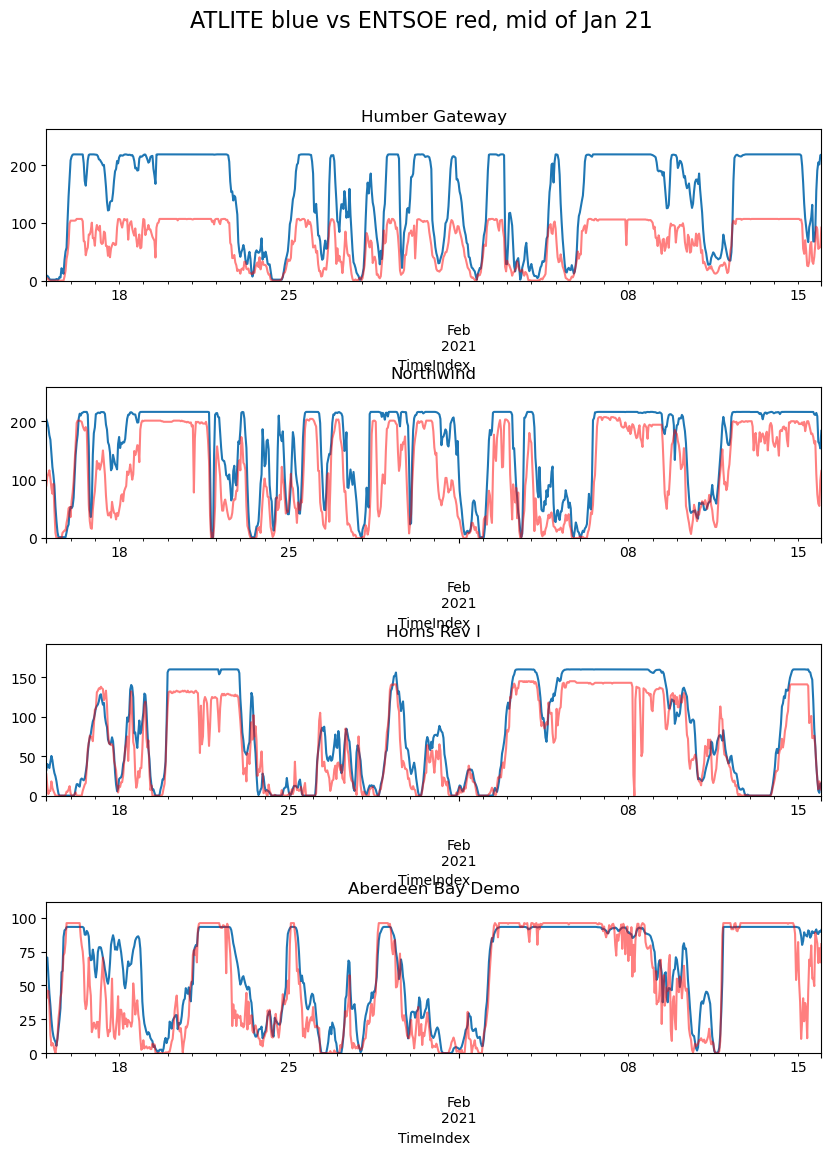

In [297]:

#fig, (ax1,ax2,ax3) =plt.subplots(3,1) #warum fehlen die Timestamps als Label?
#farms_gb['HOWAO-2'].plot(ax=ax1,color='red')
#h['Hornsea 1'].plot(ax=ax1)
#farms_dk['Horns Rev B'].plot(ax=ax2)
#h['Horns Rev 2'].plot(ax=ax2)
#farms_be['Rentel Offshore WP'].plot(ax=ax3)
#h['Rentel'].plot(ax=ax3)

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(10,12)) #warum fehlen die Timestamps als Label?
fig.suptitle('ATLITE blue vs ENTSOE red, mid of Jan 21', fontsize=16)

h1['Humber Gateway Wind Farm'].plot(ax=ax1, title= 'Humber Gateway')
farms_gb['HMGTO-1'].plot(ax=ax1,color='red',alpha=0.5)
ax1.set_ylim(0,h1['Humber Gateway Wind Farm'].max()*1.2)

h1['Northwind'].plot(ax=ax2, title= 'Northwind')
farms_be['Northwind'].plot(ax=ax2,color='red',alpha=0.5)
ax2.set_ylim(0,h1['Northwind'].max()*1.2)

# Horns rev 1 has a different set of turbines
h2['Horns Rev I'].plot(ax=ax3,title='Horns Rev I')
farms_dk['Horns Rev A'].plot(ax=ax3,color='red',alpha=0.5)
ax3.set_ylim(0,h2['Horns Rev I'].max()*1.2)


h3['Aberdeen Bay Demo'].plot(ax=ax4,title='Aberdeen Bay Demo')
farms_gb['ABRBO-1'].plot(ax=ax4,color='red',alpha=0.5)
ax4.set_ylim(0,h3['Aberdeen Bay Demo'].max()*1.2)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)

#new set
#ENTSOE name
#HMGTO-1
#Horns Rev A
#Northwind
#
#shapefile name
#
#Humber Gateway Wind Farm
#Horns Rev I
#Northwind
#
#

Text(0.5, 0.98, 'Deviations between ATLITE and ENTOSE real world data')

<AxesSubplot:title={'center':'Humber Gateway'}, xlabel='time'>

<AxesSubplot:title={'center':'Northwind'}, xlabel='time'>

<AxesSubplot:title={'center':'Horns Rev I'}, xlabel='time'>

<AxesSubplot:title={'center':'Aberdeen Bay Demo'}, xlabel='time'>

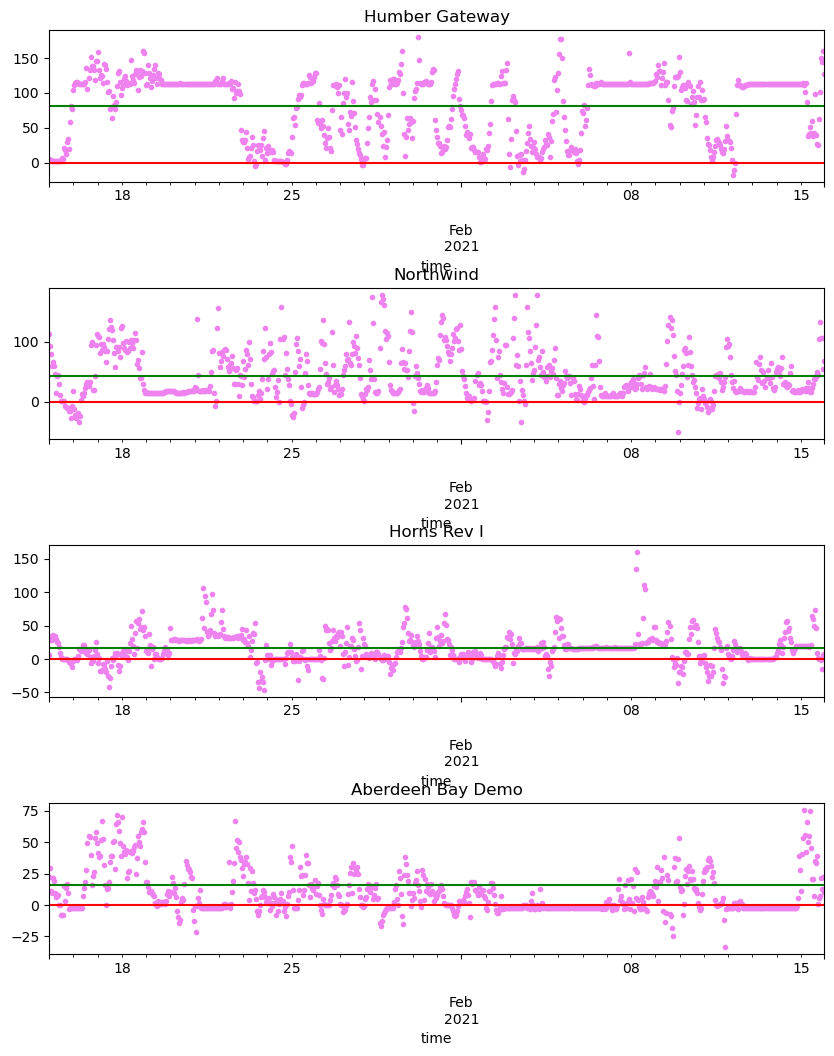

In [304]:
pd.reset_option('display.max_rows')


fig.suptitle('Deviations between ATLITE and ENTOSE real world data', fontsize=16)

fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(10,12))


#a time-zone naive df cannot be matche with a tz-Timeindex--> localize
diff1 = h1['Humber Gateway Wind Farm'].tz_localize('utc').subtract(farms_gb['HMGTO-1'])

diff1.plot(ax=ax1, title= 'Humber Gateway',color='violet',style='.')
ax1.axhline(y = 0, color = 'r', linestyle = '-')
mean1= diff1.mean()
ax1.axhline(y = mean1 , color = 'g', linestyle = '-')



diff2 = h1['Northwind'].tz_localize('utc').subtract(farms_be['Northwind'])

diff2.plot(ax=ax2, title= 'Northwind',color='violet',style='.')
ax2.axhline(y = 0, color = 'r', linestyle = '-')
mean2= diff2.mean()
ax2.axhline(y = mean2 , color = 'g', linestyle = '-')



diff3 = h2['Horns Rev I'].tz_localize('utc').subtract(farms_dk['Horns Rev A'])

diff3.plot(ax=ax3, title= 'Horns Rev I',color='violet',style='.')
ax3.axhline(y = 0, color = 'r', linestyle = '-')
mean3= diff3.mean()
ax3.axhline(y = mean3 , color = 'g', linestyle = '-')

diff4 = h3['Aberdeen Bay Demo'].tz_localize('utc').subtract(farms_gb['ABRBO-1'])

diff4.plot(ax=ax4, title= 'Aberdeen Bay Demo',color='violet',style='.')
ax4.axhline(y = 0, color = 'r', linestyle = '-')
mean4= diff4.mean()
ax4.axhline(y = mean3 , color = 'g', linestyle = '-')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.7)



Text(0.5, 0.98, 'Scatterplot that pairs every timestamp')

(TimeIndex
 2021-01-15 00:00:00+00:00     3.5
 2021-01-15 01:00:00+00:00     4.0
 2021-01-15 02:00:00+00:00     2.5
 2021-01-15 03:00:00+00:00     0.0
 2021-01-15 04:00:00+00:00     0.0
                              ... 
 2021-02-15 19:00:00+00:00    89.5
 2021-02-15 20:00:00+00:00    55.0
 2021-02-15 21:00:00+00:00    57.0
 2021-02-15 22:00:00+00:00    58.0
 2021-02-15 23:00:00+00:00    92.0
 Freq: H, Name: HMGTO-1, Length: 768, dtype: float64,
 time
 2021-01-15 00:00:00      8.679224
 2021-01-15 01:00:00      8.308458
 2021-01-15 02:00:00      6.215777
 2021-01-15 03:00:00      2.938327
 2021-01-15 04:00:00      1.638049
                           ...    
 2021-02-15 19:00:00    191.157670
 2021-02-15 20:00:00    205.034313
 2021-02-15 21:00:00    201.417455
 2021-02-15 22:00:00    217.521260
 2021-02-15 23:00:00    218.598008
 Name: Humber Gateway Wind Farm, Length: 768, dtype: float64)

Text(0.5, 1.0, 'Humber Gateway')

(0.0, 219.0)

(0.0, 219.0)

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 1.0, 'Northwind')

(0.0, 216.0)

(0.0, 216.0)

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 1.0, 'Horns Rev')

(0.0, 160.0)

(0.0, 160.0)

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

Text(0.5, 1.0, 'Aberdeen Bay Demo')

(0.0, 93.2)

(0.0, 93.2)

Text(0.5, 0, 'ENTSOE values')

Text(0, 0.5, 'ATLITE values')

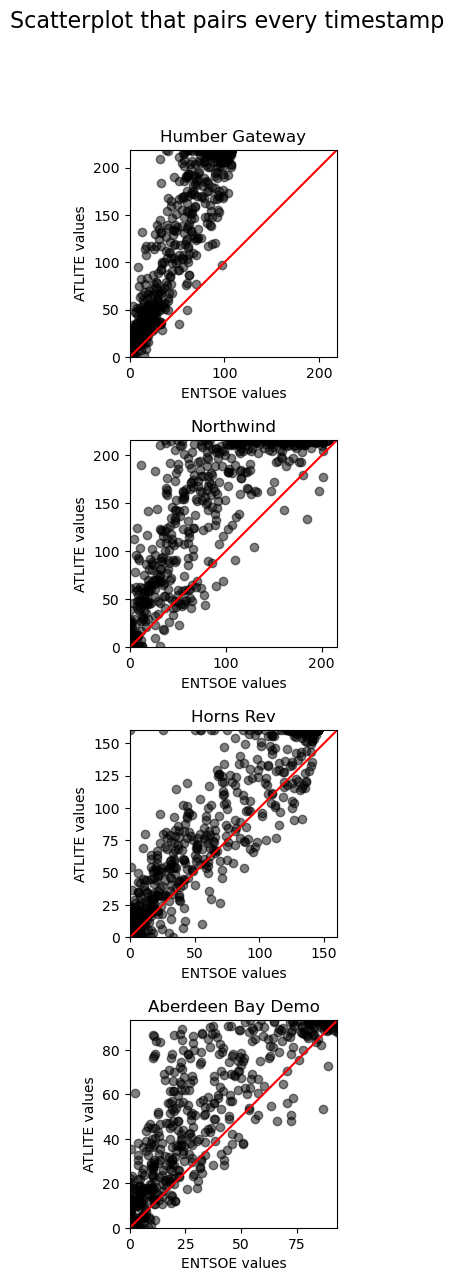

In [307]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


fig, (ax1,ax2,ax3,ax4) =plt.subplots(4,1, figsize=(5,14)) #warum fehlen die Timestamps als Label?
fig.suptitle('Scatterplot that pairs every timestamp', fontsize=16)

#the red line will always adjust to the box, thats why it will onyl be a bisecotr if we fi the plot delimitations

x1= farms_gb['HMGTO-1']
y1= h1['Humber Gateway Wind Farm']
x1,y1
ax1.scatter(x1, y1, color = 'black', alpha=0.5)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_title('Humber Gateway')
ax1.set_xlim(0,y1.max())
ax1.set_ylim(0,y1.max())

ax1.set_xlabel('ENTSOE values')
ax1.set_ylabel('ATLITE values')

ax1.set_aspect('equal', 'box')



x2= farms_be['Northwind']
y2= h1['Northwind']

ax2.scatter(x2, y2, color = 'black', alpha=0.5)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax2.transAxes
line.set_transform(transform)
ax2.add_line(line)
ax2.set_title('Northwind')
ax2.set_xlim(0,y2.max()) #if we use set_aspect, this is not necessary
ax2.set_ylim(0,y2.max())

ax2.set_xlabel('ENTSOE values')
ax2.set_ylabel('ATLITE values')
#ax2.axis('equal','box')
ax2.set_aspect('equal', 'box')



x3= farms_dk['Horns Rev A']
y3= h2['Horns Rev I']

ax3.scatter(x3, y3, color = 'black', alpha=0.5)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax3.transAxes
line.set_transform(transform)
ax3.add_line(line)
ax3.set_title('Horns Rev')
ax3.set_xlim(0,y3.max())
ax3.set_ylim(0,y3.max())

ax3.set_aspect('equal', 'box')

ax3.set_xlabel('ENTSOE values')
ax3.set_ylabel('ATLITE values')

x4= farms_gb['ABRBO-1']
y4= h3['Aberdeen Bay Demo']

ax4.scatter(x4, y4, color = 'black', alpha=0.5)
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax4.transAxes
line.set_transform(transform)
ax4.add_line(line)
ax4.set_title('Aberdeen Bay Demo')
ax4.set_xlim(0,y4.max())
ax4.set_ylim(0,y4.max())

ax4.set_aspect('equal', 'box')

ax4.set_xlabel('ENTSOE values')
ax4.set_ylabel('ATLITE values')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)



**Reference data from windatlas.xyz**

In [27]:


#this data is from windatlas.xyz
n= pd.read_csv("..\data\hywind_generation.csv",index_col='datetime')
m= pd.read_csv("..\data\horns_rev2_generation.csv", index_col='datetime')

#TODO: data are in the future to be used from
#https://transparency.entsoe.eu/ for generation units above 100 MW of isntalled capacity
#for data spanning more than a day, the entso-e transparency platform API is necessary
#n.head(10)
#m.head(10)

#slice in order to get a smaller dataframe with the same timestamps
m= m.iloc[m.index.get_loc('2019-03-01 00:00:00'):m.index.get_loc('2019-03-31 23:00:00'),:]
n= n.iloc[m.index.get_loc('2019-03-01 00:00:00'):n.index.get_loc('2019-03-31 23:00:00'),:]
len(m)
n

743

,power,cf_trace
datetime,,
2018-09-06 23:00:00,18.735,0.666370
2018-09-07 00:00:00,26.930,0.957852
2018-09-07 01:00:00,23.845,0.848124
2018-09-07 02:00:00,25.855,0.919616
2018-09-07 03:00:00,18.865,0.670994
...,...,...
2019-03-31 18:00:00,12.760,0.442518
2019-03-31 19:00:00,14.355,0.497832
2019-03-31 20:00:00,19.395,0.672620


In [28]:
m

,power,cf_trace
datetime,,
2019-03-01 00:00:00,66.35,0.326012
2019-03-01 01:00:00,96.03,0.471846
2019-03-01 02:00:00,110.54,0.543141
2019-03-01 03:00:00,126.91,0.623575
2019-03-01 04:00:00,116.59,0.572868
...,...,...
2019-03-31 18:00:00,68.07,0.330678
2019-03-31 19:00:00,75.36,0.366092
2019-03-31 20:00:00,80.27,0.389944
